# **Prepare Library**

In [1]:
# Check GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Import library
import pickle
from pickle import dump, load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
from datetime import date, datetime, timedelta
import time
from pickle import load, dump
import tensorflow as tf
import talib
import ta
import itertools as itt
from tqdm.notebook import tqdm
from scipy.stats import uniform
import os
import warnings
warnings.filterwarnings('ignore')


# Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import regularizers
from sklearn.tree import plot_tree
from xgboost import plot_importance
from lightgbm import plot_importance
from keras.losses import MeanSquaredError

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, LSTM, GRU, Flatten, Dropout, MaxPooling2D, Reshape, Bidirectional
from keras.layers import Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU, MaxPooling1D, AveragePooling1D
from keras.layers import LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# Backtest library
import vectorbt as vbt
# import backtesting as bt
# import pyfolio as pf
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

# **Function**

In [4]:
# CPCV
def cpcv_generator(t_span, num_groups, k):
    # Split data into N groups, with N << t_span (i.e. N is significantly less than t_span)
    # This will assign each index position to a group position
    group_num = np.arange(t_span) // (t_span // num_groups)
    group_num[group_num == num_groups] = num_groups-1

    # Generate the combinations
    test_groups = np.array(list(itt.combinations(np.arange(num_groups), k))).reshape(-1, k) # 15×2 matrix: [0,1],[0,2]...[0,5]...[3 5],[4 5]]
    C_nk = len(test_groups)
    n_paths = C_nk * k // num_groups

    print('Number of simulations:', C_nk) # e.g. 15
    print('Number of paths:', n_paths) # e.g. 5

    # is_test is a T x C(n, k) array where each column is a logical array indicating which observation is in the test set
    is_test_group = np.full((num_groups, C_nk), fill_value=False) # 6×15 matrix
    is_test = np.full((t_span, C_nk), fill_value=False) # 100×15 matrix or 7566×15 matrix depending on T

    # Assign test folds for each of the C(n, k) simulations
    for sim_idx, pair in enumerate(test_groups):
        i, j = pair # [0,1], [0,2],... [0,5], [1,2],..., [4,5]
        is_test_group[[i, j], sim_idx] = True # is_test_group is 6×15 matrix.
                                              # Since test_groups is [0,1], [0,2], [0,3], [0,4],... [0,5], [1,2],..., [4,5], simulation with idx 3 will consists of ticks in group 0 and 4 (i.e. the [0,4] pair)
        # Assigning the test folds
        mask = (group_num == i) | (group_num == j) # group_num = [0, 0, ..., 1, 1, ..., 2, 2, ..., 3, 3, ..., 4, 4, ...] of length 100 or 7566 (number of ticks)
                                                   # for [i,j]=[0,4] mask becomes [True, True, ..., False, False, ..., False, False, ..., False, False, ..., True, True, ...]
        is_test[mask, sim_idx] = True # Mark the rows that belong to group i,j so that they belong to sim_idx and are for testing and backtesting.
                                      # For example, since groups [0,4] belong to simulation 3, we set simulation 3 to True for all the rows that belong to group 0 or 4 to indicate that they should be used
                                      # for testing in simulation 3

    # For each path, connect the folds from different simulations to form a test path.
    # The fold coordinates are: the fold number, and the simulation index e.g. simulation 0, fold 0 etc
    path_folds = np.full((num_groups, n_paths), fill_value=np.nan)
    for p in range(n_paths):
        for group in range(num_groups):
            # The argmax() function explained: assuming is_test_group[group, :]=[F, F, F, T, F, F, F, T, F, F, T, F, T, F, T] then argmax() returns sim_idx=3
            sim_idx = is_test_group[group, :].argmax().astype(int)
            path_folds[group, p] = sim_idx  # Considering the above example where sim_idx=3 is associated with groups [0,4]:
                                            #     path_folds[0,0], path_folds[0,1],..., path_folds[0,4] will be set to sim_idx=3
                                            # Same for group 4:
                                            #     path_folds[4,0], path_folds[4,1],..., path_folds[4,4] will be set to sim_idx=3

            # Mark it as False so on the next iteration we get the next sim_idx when doing a "...argmax().astype(int)" (e.g. sim_idx=7)
            is_test_group[group, sim_idx] = False


    # Finally, for each path we indicate which simulation we're building the path from and the time indices
    paths = np.full((t_span, n_paths), fill_value= np.nan) # 100×15 matrix or 7566×5 matrix
    for p in range(n_paths):
        for g in range(num_groups):
            mask = (group_num == g) # Get all the ticks that belong to group g
            paths[mask, p] = int(path_folds[g, p])

    # Once done the matrices will look like so:
    # is_test[99] = [F, F, F, F, True, F, F, F, True, F, F, True, F, True, True]
    # paths[99] = [4, 8, 11, 13, 14]
    # path_folds[5] = [4, 8, 11, 13, 14]
    return (is_test, paths, path_folds)

def purge(t1, test_times):
    # Whatever is not in the train set should be in the test set
    train = t1.copy(deep=True)
    for test_start, test_end in test_times.items():
        df_0 = train[(test_start <= train.index) & (train.index <= test_end)].index # train starts within test
        df_1 = train[(test_start <= train) & (train <= test_end)].index # train ends within test
        df_2 = train[(train.index <= test_start) & (test_end <= train)].index # train envelopes test
        train = train.drop(df_0.union(df_1).union(df_2))
    return train


def embargo_(times, pct_embargo):
    step = int(times.shape[0] * pct_embargo)
    if step == 0:
        ans = pd.Series(times, index=test_times)
    else:
        ans = pd.Series(times[step:].values, index=times[:-step].index)
        ans = pd.concat([ans, pd.Series(times.iloc[-1], index=times[-step:].index)])
    return ans


def embargo(test_times, t1, pct_embargo=0.01):
    t1_embargo = embargo_(t1, pct_embargo) # Embargoed t1
    # Ensure the output contains only the relevant times that correspond to the indices of test_times.
    test_times_embargoed = t1_embargo.loc[test_times.index]
    return test_times_embargoed

In [5]:
# --------------------- Function: Apply Sliding Window ---------------------
def create_sliding_window(X, y, window_size=20):
    X_windowed, y_windowed = [], []

    for i in range(len(X) - window_size):
        X_windowed.append(X[i : i + window_size])  # 20-day window
        y_windowed.append(y[i + window_size])  # Target for next day

    return np.array(X_windowed), np.array(y_windowed)

In [6]:
# --------------------- Function: CPCV for ML models ---------------------
def CPCV_ML(ticker, data, num_ticks, model, params, num_paths=6, num_groups_test=2):
    t1_ = data.index
    t1 = pd.Series(t1_, index=t1_) # t1 is both the trade time and the event time

    # Realign t1
    t1 = t1.loc[data.index]

    num_groups = num_paths + 1
    is_test, paths, _ = cpcv_generator(num_ticks, num_groups, num_groups_test)
    pred = np.full(is_test.shape, np.nan)
    # Store metrics and predictions
    accuracies = []
    precision = []
    recall = []
    f1 = []
    mcc = []
    auc = []

    # CPCV Loop
    num_sim = is_test.shape[1] # num of simulations needed to generate all backtest paths
    for sim in tqdm(range(num_sim)):
        # Get train set|
        test_idx = is_test[:, sim]

        # Convert numerical indices into time stamps
        test_times = t1.loc[test_idx]

        # Embargo
        test_times_embargoed = embargo(test_times, t1, pct_embargo=0.01)

        # Purge
        train_times = purge(t1, test_times_embargoed)

        # Split training / test sets
        X_train = X.loc[train_times, :]
        y_train = y.loc[train_times]

        X_test = X.loc[test_times, :]
        y_test = y.loc[test_times]

        # Scaling
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Use RandomizedSearchCV to find best hyperparameters
        base_classifier = model

        random_search = RandomizedSearchCV(
            base_classifier,
            param_distributions=params,
            n_iter=10,  # Number of random samples
            cv=3,  # Inner cross-validation folds
            scoring='accuracy',
            n_jobs=-1
        )

        random_search.fit(X_train, y_train)
        classifier = random_search.best_estimator_  # Best model from search

        pred_ = classifier.predict(X_test)
        pred_ = pred_.reshape(-1, 1)
        pred_ = np.concatenate(pred_, axis=0)

        pred_ = (pred_ > 0.5)

        # Metrics
        accuracies.append(accuracy_score(y_test, pred_))
        precision.append(precision_score(y_test, pred_))
        recall.append(recall_score(y_test, pred_))
        f1.append(f1_score(y_test, pred_))
        mcc.append(matthews_corrcoef(y_test, pred_))
        auc.append(roc_auc_score(y_test, pred_))

        # Fill the backtesting prediction matrix
        pred[test_idx, sim] = pred_
    results = pd.DataFrame({
    'Ticker': [ticker] * len(accuracies),
    'Accuracy': accuracies,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1,
    'MCC': mcc,
    'AUC': auc
    })
    return results, pred, paths

In [7]:
# --------------------- Function: CPCV for DL models ---------------------
def CPCV_DL(ticker, data, num_ticks, model, num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False):
    # Define EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    if MLP_type==False:
        t1_ = data[:-time_steps].index
        t1 = pd.Series(t1_, index=t1_)  # t1 is both the trade time and event time
        t1 = t1.loc[data[:-time_steps].index]  # Realign t1
    else:
        t1_ = data.index
        t1 = pd.Series(t1_, index=t1_)  # t1 is both the trade time and event time
        t1 = t1.loc[data.index]  # Realign t1
    
    num_groups = num_paths + 1
    is_test, paths, _ = cpcv_generator(num_ticks, num_groups, num_groups_test)
    pred = np.full(is_test.shape, np.nan)
    # Store metrics and predictions
    accuracies = []
    precision = []
    recall = []
    f1 = []
    mcc = []
    auc = []

    # CPCV Loop
    num_sim = is_test.shape[1] # num of simulations needed to generate all backtest paths
    for sim in tqdm(range(num_sim)):
        # Get train set|
        test_idx = is_test[:, sim]

        # Convert numerical indices into time stamps
        test_times = t1.loc[test_idx]

        # Embargo
        test_times_embargoed = embargo(test_times, t1, pct_embargo=0.01)

        # Purge
        train_times = purge(t1, test_times_embargoed)

        if MLP_type==False:
            # Split training/testing sets
            X_train = X_windowed[train_times.index, :, :]
            y_train = y_windowed[train_times.index]
            X_test = X_windowed[test_times.index, :, :]
            y_test = y_windowed[test_times.index]

            # Standardization
            scaler = StandardScaler()
            X_train_shape = X_train.shape
            X_test_shape = X_test.shape
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train_shape[2])).reshape(X_train_shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test_shape[2])).reshape(X_test_shape)
        else:
            # Split training/testing sets
            X_train = X.loc[train_times, :]
            y_train = y.loc[train_times]
            X_test = X.loc[test_times, :]
            y_test = y.loc[test_times]
            # Scaling
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # Use RandomizedSearchCV to find best hyperparameters
        model = model

        # Fit with early stopping
        model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=[early_stopping], validation_split=0.2, verbose=0)

        pred_ = (model.predict(X_test) > 0.5).astype(int).flatten()
        pred[test_idx, sim] = pred_

        # Metrics
        accuracies.append(accuracy_score(y_test, pred_))
        precision.append(precision_score(y_test, pred_))
        recall.append(recall_score(y_test, pred_))
        f1.append(f1_score(y_test, pred_))
        mcc.append(matthews_corrcoef(y_test, pred_))
        auc.append(roc_auc_score(y_test, pred_))

        # Fill the backtesting prediction matrix
        pred[test_idx, sim] = pred_
    results = pd.DataFrame({
    'Ticker': [ticker] * len(accuracies),
    'Accuracy': accuracies,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1,
    'MCC': mcc,
    'AUC': auc
    })
    return results, pred, paths

In [8]:
# --------------------- Function: Create backtest portfolio ---------------------
def Backtest(data, pred, paths, time_steps=0, fixed_fees=0.001, slippage=0.001):
    backtest_signals = pd.DataFrame(index=data['Date'][time_steps:], columns=[f'path_{p}' for p in range(paths.shape[1])])

    # Iterate over backtest paths
    for p in range(paths.shape[1]):
        for t, sim in enumerate(paths[:, p]):  # index, value
            backtest_signals.iloc[t, p] = pred[t, int(sim)]  # Keep signal values (1 or 0)

    # Convert signals to numeric (ensuring they are 1s and 0s)
    backtest_signals = backtest_signals.astype(float)

    # Add close price column for vbt.Portfolio
    backtest_signals['close'] = data['close'][time_steps:].values
    backtest_signals['BnH'] = [1]*len(backtest_signals)
    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=backtest_signals['close'],
        entries=backtest_signals.drop(['close'],axis=1) == 1,  # Entries where signal is 1
        exits=backtest_signals.drop(['close'],axis=1) == 0,  # Exits where signal is 0
        size=1,  # Assuming equal position size
        fixed_fees=fixed_fees,  # Example transaction cost
        slippage=slippage,
        freq='1d'
    )

    return portfolio, backtest_signals

# --------------------- Function: Plot backtest paths ---------------------
def plot_backtest(portfolio, ticker, model_type):
    cum_returns = (1 + portfolio.returns()).cumprod() - 1  # Compute cumulative return

    # ✅ Plot multiple strategies manually
    plt.figure(figsize=(12, 6))
    for col in cum_returns.columns:
        plt.plot(cum_returns.index, cum_returns[col], label=col)
    mean_cum_return = cum_returns.mean(axis=1)
    # Plot mean cumulative return (bold black line)
    plt.plot(cum_returns.index, mean_cum_return, label="Mean Strategy", linewidth=2, color="black")
    plt.legend()
    plt.title(f'Cumulative Returns of {model_type} Strategies on {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid()
    plt.show()

# --------------------- Function: Trading metrics ---------------------
def backtest_metrics(portfolio):
    return portfolio.returns_stats()


In [9]:
def get_X_y_GAN(X_data, y_data, n_steps_in, n_steps_out):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == n_steps_in and len(y_value) == n_steps_out:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# RMSE
def rmspe(y_true, y_pred):
    # Calculate Mean Squared Error
    mse = np.mean(np.square(y_true - y_pred))
    # Calculate RMSPE
    return np.sqrt(mse) / np.mean(y_true)



# **Model**

# **Work**

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 10ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 2ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 3ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 6ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 5ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 5ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 0s 10ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

40/40 [==============================] - 1s 8ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Saved model performance metrics to model_performance_metrics.csv


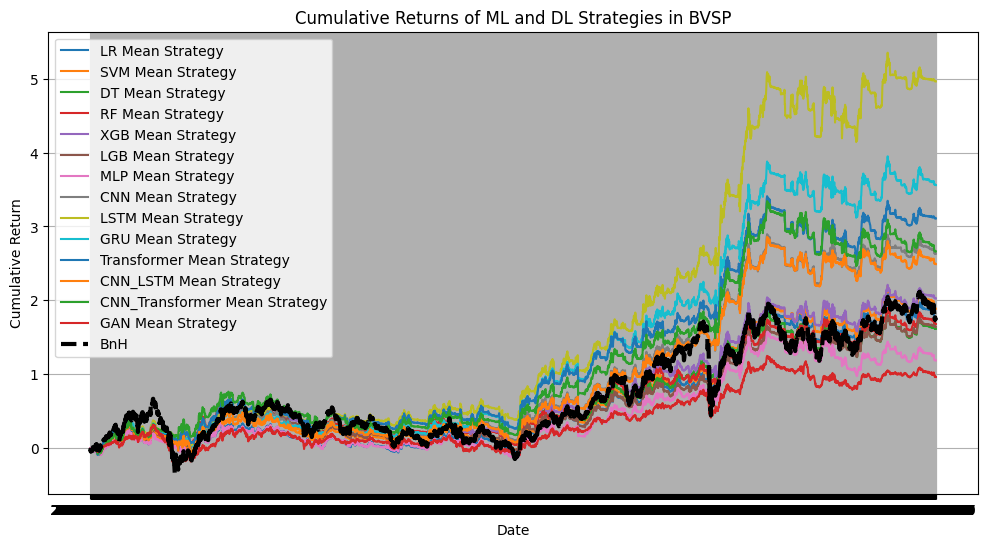

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 1s 10ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 0s 2ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 0s 3ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 0s 7ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 0s 5ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 0s 5ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 1s 13ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

54/54 [==============================] - 2s 8ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Saved model performance metrics to model_performance_metrics.csv


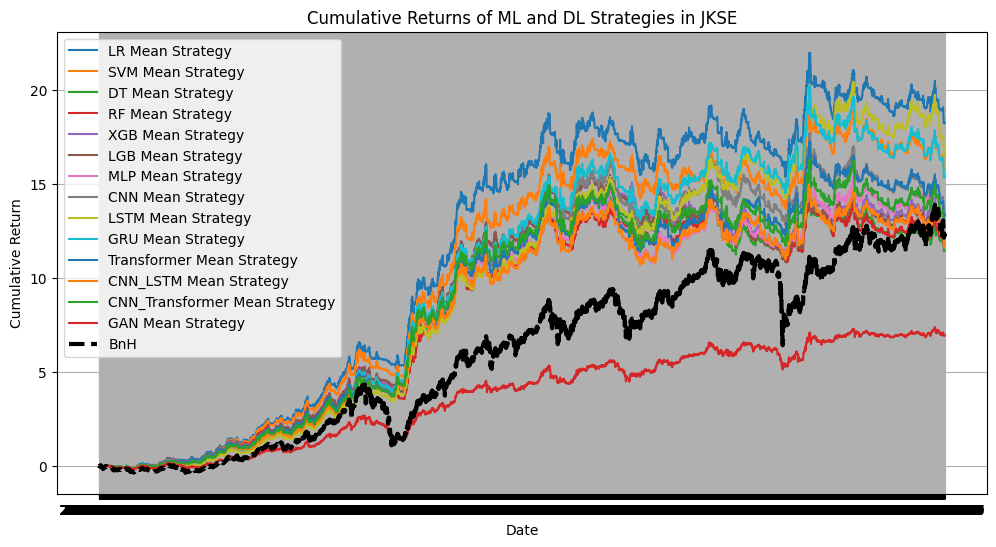

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 1s 10ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 0s 2ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 0s 4ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 0s 8ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 0s 4ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 0s 6ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 1s 13ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

53/53 [==============================] - 2s 9ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Saved model performance metrics to model_performance_metrics.csv


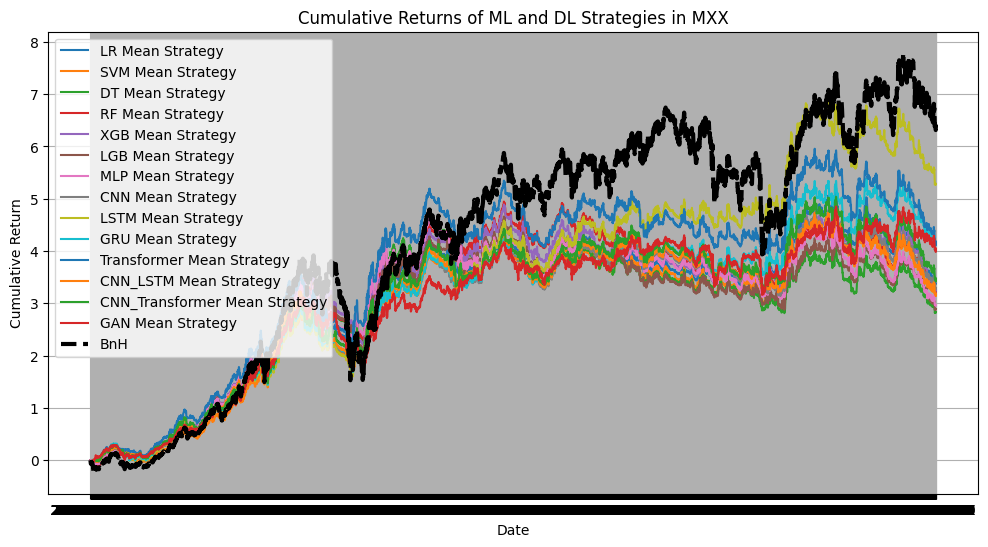

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 0s 10ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 0s 2ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 0s 3ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 0s 7ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 0s 5ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 0s 6ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 1s 14ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

37/37 [==============================] - 1s 8ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Saved model performance metrics to model_performance_metrics.csv


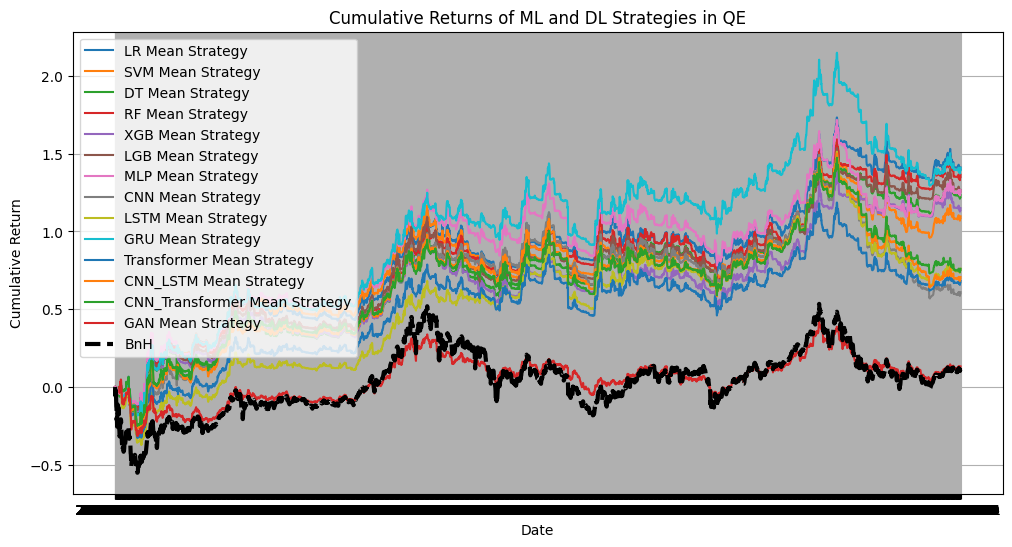

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 0s 10ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 0s 2ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 0s 4ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 0s 7ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 0s 4ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 0s 6ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 1s 12ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

47/47 [==============================] - 2s 7ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Saved model performance metrics to model_performance_metrics.csv


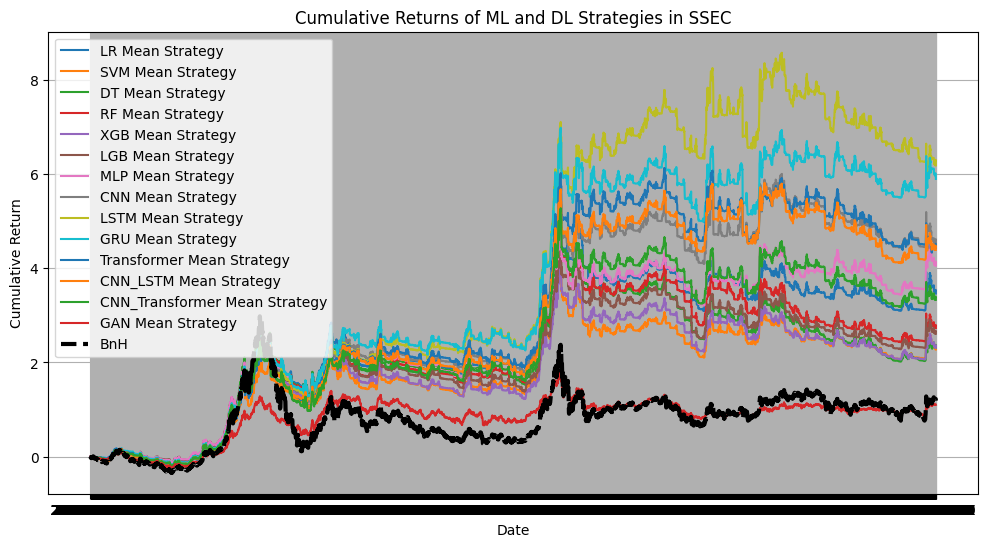

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 11ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 2ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 5ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 7ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 6ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 7ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 0s 13ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

29/29 [==============================] - 1s 9ms/step
Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Number of simulations: 21
Number of paths: 6


  0%|          | 0/21 [00:00<?, ?it/s]

Saved model performance metrics to model_performance_metrics.csv


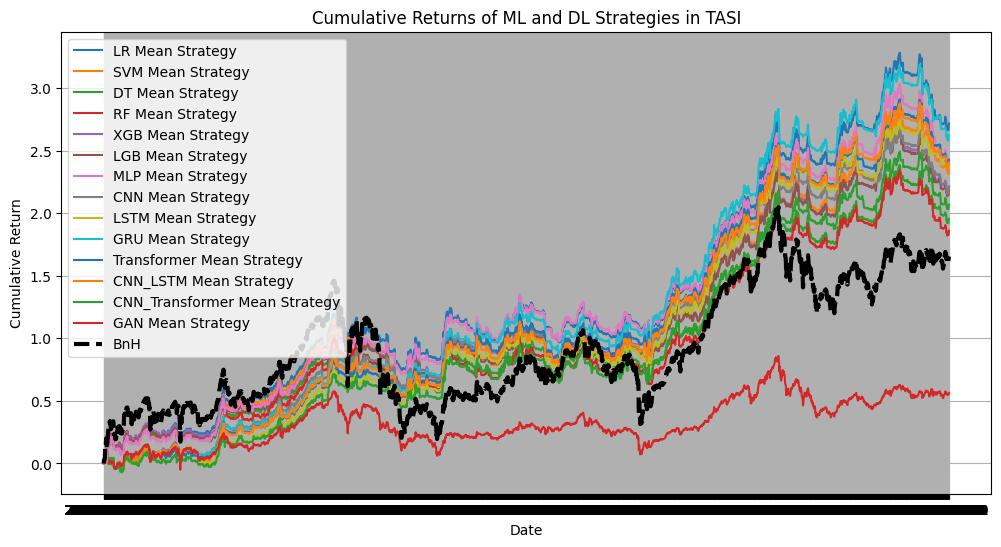

In [10]:
emerging = [ 'BVSP', 'JKSE', 'MXX', 'QE', 'SSEC', 'TASI']
for ticker in emerging:
    # Set data
    data = pd.read_csv(f'{ticker}.csv', index_col=0)
    X = data.drop(['Target_20', 'Return_20d', 'Date'], axis=1)
    y = data["Target_20"]
    X_windowed, y_windowed = create_sliding_window(X.values, y.values, window_size=20)
    time_steps = 20
    num_ticks_ML = len(X)
    num_ticks_DL = len(X_windowed)

    # --------------------- ML models ---------------------
    # LR
    LR = LogisticRegression(solver='liblinear')
    LR_params = {
        'C': [0.1, 0.5, 1.0],  # Regularization strength
        'penalty': ['l1', 'l2'],  # Type of regularization
        'solver': ['liblinear'],  # Solver compatible with L1/L2 penalty
        'class_weight': ['balanced', None]  # Class weights
    }
    
    # SVM
    SVM = SVC(probability=True)
    SVM_params = {
        'C': [0.1, 0.5, 1.0],  # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
        'gamma': ['scale', 'auto'],  # Kernel coefficient
    }
    
    # DT
    DT = DecisionTreeClassifier()
    DT_params = {
        'max_depth': [3, 5, 7],          # Fewer options for tree depth
        'min_samples_split': [2, 3],     # Limited choices for splitting
        'min_samples_leaf': [2, 3],      # Fewer options for leaf nodes
        'criterion': ['gini', 'entropy'],   # Split criteria
    }
    
    # RF
    RF = RandomForestClassifier()
    RF_params = {
        'n_estimators': [50, 100],  # Number of trees in the forest
        'max_depth': [3, 5, 7],  # Maximum depth of the tree
        'min_samples_split': [2, 3],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
        'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    }
    
    # XGB
    XGB = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
    XGB_params = {
        'n_estimators': [50, 100],         # Number of boosting rounds
        'max_depth': [3, 5],                 # Depth of each tree
        'learning_rate': [0.01, 0.05],     # Step size shrinkage
        'subsample': [0.6, 0.8],           # Row sampling ratio
        'colsample_bytree': [0.6, 0.8],    # Column sampling ratio per tree
        'gamma': [0, 1],                     # Minimum loss reduction to split
        'reg_alpha': [0, 0.1],               # L1 regularization term
        'reg_lambda': [1, 2]               # L2 regularization term
    }
    
    # LGB
    LGB = lgb.LGBMClassifier(objective='binary', verbose=-1)
    LGB_params = {
        'num_leaves': [7, 10],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'min_data_in_leaf': [1, 5, 10]
    }
    
    # --------------------- DL models ---------------------
    
    # Define EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    
    #------------------------------------------------------------------------
    def MLP_model(learning_rate=0.001):
        model = Sequential([
            Dense(128, activation='relu', input_dim=X.shape[1]),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid')  # Output layer for binary classification
        ])
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
        return model
        
    #------------------------------------------------------------------------
    def CNN_model(learning_rate=0.001):
        model = Sequential([
            Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(20, X.shape[1], 1), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
            Dropout(0.2),
    
            Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
            Dropout(0.2),
    
            Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
            Dropout(0.2),
    
            Flatten(),
            Dense(units=128, activation='relu'),
            Dropout(0.2),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    #------------------------------------------------------------------------
    def LSTM_model(learning_rate=0.001):
        model = Sequential([
            LSTM(units=64, return_sequences=True, input_shape=(20, X.shape[1]), kernel_regularizer=regularizers.l2(1e-3)),  # First LSTM layer
            Dropout(0.2),
            LSTM(units=128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3)),  # Second LSTM layer (stacked)
            Dropout(0.2),
            LSTM(units=128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-3)),  # Third LSTM layer (final layer)
            Dropout(0.2),
            Dense(units=128, activation='relu'),
            Dropout(0.3),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    #------------------------------------------------------------------------
    def GRU_model(learning_rate=0.001):
        model = Sequential([
            GRU(units=64, return_sequences=True, input_shape=(20, X.shape[1])),  # First GRU layer
            Dropout(0.2),
            GRU(units=128, return_sequences=True),  # Second GRU layer (stacked)
            Dropout(0.2),
            GRU(units=128, return_sequences=False),  # Third GRU layer (final layer)
            Dropout(0.2),
            Dense(units=128, activation='relu'),
            Dropout(0.2),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    #--------------------------- Transformer Models ---------------------------------------------
    
    # Positional Encoding Layer
    class PositionalEncoding(layers.Layer):
        def __init__(self, sequence_len, model_dim):
            super(PositionalEncoding, self).__init__()
            self.pos_encoding = self.get_positional_encoding(sequence_len, model_dim)
    
        def get_positional_encoding(self, seq_len, d_model):
            pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
            angle_rates = 1 / tf.pow(10000.0, (2 * (i//2)) / tf.cast(d_model, tf.float32))
            angle_rads = pos * angle_rates
            sines = tf.math.sin(angle_rads[:, 0::2])
            cosines = tf.math.cos(angle_rads[:, 1::2])
            pos_encoding = tf.concat([sines, cosines], axis=-1)
            pos_encoding = pos_encoding[tf.newaxis, ...]
            return tf.cast(pos_encoding, dtype=tf.float32)
    
        def call(self, x):
            pos_encoding = tf.cast(self.pos_encoding[:, :tf.shape(x)[1], :], x.dtype)
            return x + pos_encoding
    
    
    
    # Transformer Encoder Block
    def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.4):
        # Multi-Head Self Attention
        x = LayerNormalization(epsilon=1e-6)(inputs)
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = Dropout(dropout)(x)
        res = x + inputs  # Residual Connection
    
        # Feed Forward Part
        x = LayerNormalization(epsilon=1e-6)(res)
        x = Dense(ff_dim, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(dropout)(x)
        x = Dense(inputs.shape[-1])(x)
        return x + res  # Residual Connection
    
    # Complete Transformer Model
    def Transformer_model(learning_rate=0.001, input_shape=(20, 105), head_size=32, num_heads=2, ff_dim=32, num_layers=2, dropout=0.4, num_classes=1):
        inputs = Input(shape=input_shape)
    
        # Positional Encoding
        x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)
    
        # Transformer Blocks
        for _ in range(num_layers):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
        # Global Average Pooling
        x = GlobalAveragePooling1D()(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dropout(dropout)(x)
    
        # Output Layer for Classification
        outputs = Dense(num_classes, activation="sigmoid", kernel_regularizer=regularizers.l2(1e-3))(x)
    
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
        return model
    
    #--------------------------- Hybrid Models ---------------------------------------------
    def CNN_LSTM_model(input_shape=(20, 105, 1), learning_rate=0.001):
        model = Sequential()
    
        # CNN feature extraction
        model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))
    
        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))
    
        model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
        model.add(Dropout(0.2))
    
        # Replace Flatten with GlobalAveragePooling2D
        model.add(Flatten())  
    
        # Reshape for LSTM input (Ensure timesteps are valid)
        model.add(Reshape((1, -1)))  # Single timestep
    
        # LSTM sequence learning
        model.add(LSTM(units=128, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=128))
        model.add(Dropout(0.2))
    
        # Layer Normalization
        model.add(LayerNormalization())
    
        # Fully connected layers
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))  
    
        # Compile model
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        
        return model
    
    def CNN_Transformer_model(input_shape=(20, 105), head_size=32, num_heads=2, ff_dim=32, num_layers=2, dropout=0.4, num_classes=1, learning_rate=0.001):
        inputs = Input(shape=input_shape)
    
        # CNN Feature Extraction
        x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
        x = Dropout(0.2)(x)
    
        x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
        x = Dropout(0.2)(x)
    
        x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
        x = Dropout(0.2)(x)
    
        # Positional Encoding
        x = PositionalEncoding(x.shape[1], x.shape[2])(x)
    
        # Transformer Blocks
        for _ in range(num_layers):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
        # Global Average Pooling
        x = GlobalAveragePooling1D()(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dropout(dropout)(x)
    
        # Output Layer
        outputs = Dense(num_classes, activation="sigmoid", kernel_regularizer=regularizers.l2(1e-3))(x)
    
        # Build Model
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
        return model
    
    # -----------------------------------------GAN ---------------------------------------
    # Define the Generator
    def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
        model = Sequential()
        model.add(LSTM(units=128,
                      return_sequences=True,
                      input_shape=(input_dim, feature_size),
                       kernel_regularizer=regularizers.l2(1e-3)
                      ))
        model.add(LSTM(units=128,
                      return_sequences=True,
                       kernel_regularizer=regularizers.l2(1e-3)
                      ))
        model.add(LSTM(units=64,
                       kernel_regularizer=regularizers.l2(1e-3)
                      ))
        model.add(Dense(128,
                      kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dense(units=output_dim, dtype=tf.float32))
        return model
    
    # Define the discriminator
    def Discriminator(n_steps_in) -> tf.keras.models.Model:
        model = tf.keras.Sequential()
        model.add(Conv1D(32, input_shape=(n_steps_in+1, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
        model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
        model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
        model.add(Flatten())
        model.add(Dense(220, use_bias=True))
        model.add(LeakyReLU())
        model.add(Dense(220, use_bias=True))
        model.add(ReLU())
        model.add(Dense(1, dtype=tf.float32))
        return model
    
    # Train WGAN-GP model
    class GAN():
        def __init__(self, generator, discriminator):
            super(GAN, self).__init__()
            self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
            self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
            self.generator = generator
            self.discriminator = discriminator
            self.batch_size = 128
            checkpoint_dir = '../training_checkpoints'
            self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                                  discriminator_optimizer=self.d_optimizer,
                                                  generator=self.generator,
                                                  discriminator=self.discriminator)
    
            # Save best model
            self.best_model_path = 'best_gen_GRU_model.keras'
    
            # For tracking best validation loss
            self.best_val_loss = float('inf')
    
    
        def gradient_penalty(self, batch_size, real_output, fake_output):
            """ Calculates the gradient penalty.
    
            This loss is calculated on an interpolated image
            and added to the discriminator loss.
            """
            # get the interpolated data
            alpha = tf.random.normal([batch_size, 21, 1], 0.0, 1.0)
            diff = fake_output - tf.cast(real_output, tf.float32)
            interpolated = tf.cast(real_output, tf.float32) + alpha * diff
    
            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolated)
                # 1. Get the discriminator output for this interpolated image.
                pred = self.discriminator(interpolated, training=True)
    
            # 2. Calculate the gradients w.r.t to this interpolated image.
            grads = gp_tape.gradient(pred, [interpolated])[0]
    
            # 3. Calcuate the norm of the gradients
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    
            gp = tf.reduce_mean((norm - 1.0) ** 2)
            return gp
    
        def train_step(self, data):
            real_input, real_price, yc = data
            batch_size = tf.shape(real_input)[0]
            for _ in range(1):
                with tf.GradientTape() as d_tape:
                    # Train the discriminator
                    # generate fake output
                    generated_data = self.generator(real_input, training=True)
                    # reshape the data
                    generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                    fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                    real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                    real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                    # Get the logits for the fake images
                    D_real = self.discriminator(real_output, training=True)
                    # Get the logits for real images
                    D_fake = self.discriminator(fake_output, training=True)
                    # Calculate discriminator loss using fake and real logits
                    real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                    fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                    d_cost = fake_loss-real_loss
                    # Calculate the gradientjiu penalty
                    gp = self.gradient_penalty(batch_size, real_output, fake_output)
                    # Add the gradient penalty to the original discriminator loss
                    d_loss = d_cost + gp * 10
    
                d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
                self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
            for _ in range(3):
                with tf.GradientTape() as g_tape:
                    # Train the generator
                    # generate fake output
                    generated_data = self.generator(real_input, training=True)
                    # reshape the data
                    generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                    fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                    # Get the discriminator logits for fake images
                    G_fake = self.discriminator(fake_output, training=True)
                    # Calculate the generator loss
                    g_loss = -tf.reduce_mean(G_fake)
                g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
                self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
    
            return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}
    
        def train(self, X_train, y_train, yc, epochs):
            data = X_train, y_train, yc
            train_hist = {}
            train_hist['D_losses'] = []
            train_hist['G_losses'] = []
            train_hist['per_epoch_times'] = []
            train_hist['total_ptime'] = []
    
    
            for epoch in range(epochs):
                start = time.time()
    
                real_price, fake_price, loss = self.train_step(data)
    
                G_losses = []
                D_losses = []
    
                Real_price = []
                Predicted_price = []
    
                D_losses.append(loss['d_loss'].numpy())
                G_losses.append(loss['g_loss'].numpy())
    
                Predicted_price.append(fake_price)
                Real_price.append(real_price)
    
                # Calculate validation loss
                val_pred = self.generator(X_train, training=False)
                val_loss = tf.reduce_mean(tf.keras.losses.MSE(y_train, val_pred))
    
                # Save best model
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    tf.keras.models.save_model(generator, self.best_model_path)
                    # print(f"Best model saved at epoch {epoch+1} with val_loss: {val_loss.numpy()}")
    
                # # Save the model every 15 epochs
                # if (epoch + 1) % 15 == 0:
                #     tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % epoch)
                #     tf.keras.models.save_model(discriminator, 'dis_CNN_model%d.h5' % epoch)
                #     self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                #     print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
    
                # For printing loss
                epoch_end_time = time.time()
                per_epoch_ptime = epoch_end_time - start
                train_hist['D_losses'].append(D_losses)
                train_hist['G_losses'].append(G_losses)
                train_hist['per_epoch_times'].append(per_epoch_ptime)
    
            # Reshape the predicted result & real
            Predicted_price = np.array(Predicted_price)
            Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
            Real_price = np.array(Real_price)
            Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])
    
            return Predicted_price, Real_price, rmspe(Predicted_price,Real_price)
    
        def predict(self, X_test, training = False):
            # Load the best saved model
            G_model = tf.keras.models.load_model(self.best_model_path)
    
            # Recompile the model (only needed if training again)
            # G_model.compile(
            #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            #     loss=tf.keras.losses.BinaryCrossentropy(),  # Use your appropriate loss function
            #     metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]  # Add relevant metrics
            # )
    
            # Generate predictions
            y_pred = G_model.predict(X_test)
    
            return y_pred
    
    #===============================================Training=======================================================    
    # ---------------------------------------- DL models ---------------------------------------------
    
        # Transformer
    Transformer_model = Transformer_model(learning_rate=0.0005)
    Transformer_result_df, Transformer_pred, Transformer_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_DL, model=Transformer_model, 
                                                                         num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False)
    Transformer_result_df.to_csv(f'{ticker}_Transformer.csv', index=False)
    Transformer_portfolio, Transformer_signal = Backtest(data, Transformer_pred, Transformer_paths,time_steps=20)
        
        # MLP
    MLP_model = MLP_model(learning_rate=0.0005)
    MLP_result_df, MLP_pred, MLP_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_ML, model=MLP_model, 
                                                 num_paths=6, num_groups_test=2, time_steps=20, MLP_type=True)
    MLP_result_df.to_csv(f'{ticker}_MLP.csv', index=False)
    MLP_portfolio, MLP_signal = Backtest(data, MLP_pred, MLP_paths,time_steps=0)
    
        # CNN
    CNN_model = CNN_model(learning_rate=0.0005)
    CNN_result_df, CNN_pred, CNN_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_DL, model=CNN_model, 
                                                 num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False)
    CNN_result_df.to_csv(f'{ticker}_CNN.csv', index=False)
    CNN_portfolio, CNN_signal = Backtest(data, CNN_pred, CNN_paths,time_steps=20)
        
        # LSTM
    LSTM_model = LSTM_model(learning_rate=0.0005)
    LSTM_result_df, LSTM_pred, LSTM_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_DL, model=LSTM_model, 
                                                    num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False)
    LSTM_result_df.to_csv(f'{ticker}_LSTM.csv', index=False)
    LSTM_portfolio, LSTM_signal = Backtest(data, LSTM_pred, LSTM_paths,time_steps=20)
        
        # GRU
    GRU_model = GRU_model(learning_rate=0.0005)
    GRU_result_df, GRU_pred, GRU_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_DL, model=GRU_model, 
                                                 num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False)
    GRU_result_df.to_csv(f'{ticker}_GRU.csv', index=False)
    GRU_portfolio, GRU_signal = Backtest(data, GRU_pred, GRU_paths,time_steps=20)
        
        # CNN-LSTM
    CNN_LSTM_model = CNN_LSTM_model(learning_rate=0.0005)
    CNN_LSTM_result_df, CNN_LSTM_pred, CNN_LSTM_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_DL, model=CNN_LSTM_model, 
                                                                num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False)
    CNN_LSTM_result_df.to_csv(f'{ticker}_CNN_LSTM.csv', index=False)
    CNN_LSTM_portfolio, CNN_LSTM_signal = Backtest(data, CNN_LSTM_pred, CNN_LSTM_paths,time_steps=20)
        
        # CNN-Transformer
    CNN_Transformer_model = CNN_Transformer_model(learning_rate=0.0005)
    CNN_Transformer_result_df, CNN_Transformer_pred, CNN_Transformer_paths = CPCV_DL(ticker=ticker, data=data, num_ticks=num_ticks_DL, model=CNN_Transformer_model, 
                                                                                     num_paths=6, num_groups_test=2, time_steps=20, MLP_type=False)
    CNN_Transformer_result_df.to_csv(f'{ticker}_CNN_Transformer.csv', index=False)
    CNN_Transformer_portfolio, CNN_Transformer_signal = Backtest(data, CNN_Transformer_pred, CNN_Transformer_paths,time_steps=20)
    
        # ---------------------- GAN -------------------------------------
    X_value = pd.DataFrame(X)
    y_value = pd.DataFrame(data['Return_20d'])
        
    n_steps_in = 20
    n_features = X_value.shape[1]
    n_steps_out = 1
        
        # Scale the data
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
        
    X_scale_dataset = X_scaler.fit_transform(X_value)
    y_scale_dataset = y_scaler.fit_transform(y_value)
        
        # Process data
    X_gan, y_gan, yc = get_X_y_GAN(X_scale_dataset, y_scale_dataset, n_steps_in, n_steps_out)
    
        # --------------------- CPCV & Data Processing ---------------------
    t1_ = data[:-n_steps_in].index
    t1 = pd.Series(t1_, index=t1_)  # t1 is both the trade time and event time
    t1 = t1.loc[data[:-n_steps_in].index]  # Realign t1
        
    num_paths = 6
    num_groups_test = 2
    num_groups = num_paths + 1
    num_ticks = len(X_gan)
    is_test, paths, _ = cpcv_generator(num_ticks, num_groups, num_groups_test)
        
    pred = np.full(is_test.shape, np.nan)
        
        # Store metrics and predictions
    all_accuracies = []
    all_precision = []
    all_recall = []
    all_f1 = []
    all_mcc = []
    all_auc = []
        
        # --------------------- CPCV Loop ---------------------
    num_sim = is_test.shape[1]  # Number of CPCV simulations
        
    for sim in tqdm(range(num_sim)):
            # Get train/test indices
            test_idx = is_test[:, sim]
            test_times = t1.loc[test_idx]  # Select test times
        
            # Update `test_idx` to reflect the new `test_times`
            test_idx = np.where(is_test[:, sim])[0]
        
            # Embargo & Purge
            test_times_embargoed = embargo(test_times, t1, pct_embargo=0.01)
            train_times = purge(t1, test_times_embargoed)
        
            # Split training/testing sets
            X_train_gan = X_gan[train_times.index, :, :]
            y_train_gan = y_gan[train_times.index]
            yc_train = yc[train_times.index]
        
            X_test_gan = X_gan[test_times.index, :, :]
            y_test_gan = y_gan[test_times.index]
            yc_test = yc[test_times.index]
            y_test = y[test_times.index]
        
            # Train WGAN model
            input_dim = X_train_gan.shape[1]
            feature_size = X_train_gan.shape[2]
            output_dim = y_train_gan.shape[1]
            epoch = 50
        
            generator = Generator(X_train_gan.shape[1], output_dim, X_train_gan.shape[2])
            discriminator = Discriminator(n_steps_in)
            gan = GAN(generator, discriminator)
            Predicted_price, Real_price, RMSPE = gan.train(X_train_gan, y_train_gan, yc_train, epochs=50)
        
            # Predictions
            y_pred = gan.predict(X_test_gan)
            rescaled_predicted_y = y_scaler.inverse_transform(y_pred)
        
            # Combine predictions and real values into a single DataFrame
            y_predict = (y_pred.flatten()> 0.0).astype(int)
            pred[test_idx, sim] = (y_predict)
        
            # Store Metrics
            all_accuracies.append(accuracy_score(y_test, y_predict))
            all_precision.append(precision_score(y_test, y_predict))
            all_recall.append(recall_score(y_test, y_predict))
            all_f1.append(f1_score(y_test, y_predict))
            all_mcc.append(matthews_corrcoef(y_test, y_predict))
            all_auc.append(roc_auc_score(y_test, y_predict))
    GAN_result_df = pd.DataFrame({
        'Ticker': [ticker] * len(all_accuracies),
        'Accuracy': all_accuracies,
        'Precision': all_precision,
        'Recall': all_recall,
        'F1_Score': all_f1,
        'MCC': all_mcc,
        'AUC': all_auc
        })
    
    GAN_pred = pred
    GAN_paths = paths
    GAN_result_df.to_csv(f'{ticker}_GAN.csv', index=False)
    GAN_portfolio, GAN_signal = Backtest(data, GAN_pred, GAN_paths,time_steps=20)
        
    
        # ---------------------------------------- ML models ---------------------------------------------
        # LR model
    LR_result_df, LR_pred, LR_paths = CPCV_ML(ticker=ticker, data=data, num_ticks=num_ticks_ML, 
                                                      model=LR, params=LR_params, num_paths=6, num_groups_test=2)
    LR_result_df.to_csv(f'{ticker}_LR.csv', index=False)
    LR_portfolio, LR_signal = Backtest(data, LR_pred, LR_paths,time_steps=0)
        
        # SVM model
    SVM_result_df, SVM_pred, SVM_paths = CPCV_ML(ticker=ticker, data=data, num_ticks=num_ticks_ML, 
                                                      model=SVM, params=SVM_params, num_paths=6, num_groups_test=2)
    SVM_result_df.to_csv(f'{ticker}_SVM.csv', index=False)
    SVM_portfolio, SVM_signal = Backtest(data, SVM_pred, SVM_paths,time_steps=0)
        
        # DT model
    DT_result_df, DT_pred, DT_paths = CPCV_ML(ticker=ticker, data=data, num_ticks=num_ticks_ML, 
                                                      model=DT, params=DT_params, num_paths=6, num_groups_test=2)
    DT_result_df.to_csv(f'{ticker}_DT.csv', index=False)
    DT_portfolio, DT_signal = Backtest(data, DT_pred, DT_paths,time_steps=0)
        
        # RF model
    RF_result_df, RF_pred, RF_paths = CPCV_ML(ticker=ticker, data=data, num_ticks=num_ticks_ML, 
                                                      model=RF, params=RF_params, num_paths=6, num_groups_test=2)
    RF_result_df.to_csv(f'{ticker}_RF.csv', index=False)
    RF_portfolio, RF_signal = Backtest(data, RF_pred, RF_paths,time_steps=0)
        
        # XGB model
    XGB_result_df, XGB_pred, XGB_paths = CPCV_ML(ticker=ticker, data=data, num_ticks=num_ticks_ML, 
                                                      model=XGB, params=XGB_params, num_paths=6, num_groups_test=2)
    XGB_result_df.to_csv(f'{ticker}_XGB.csv', index=False)
    XGB_portfolio, XGB_signal = Backtest(data, XGB_pred, XGB_paths,time_steps=0)
        
        # LGB model
    LGB_result_df, LGB_pred, LGB_paths = CPCV_ML(ticker=ticker, data=data, num_ticks=num_ticks_ML, 
                                                      model=LGB, params=LGB_params, num_paths=6, num_groups_test=2)
    LGB_result_df.to_csv(f'{ticker}_LGB.csv', index=False)
    LGB_portfolio, LGB_signal = Backtest(data, LGB_pred, LGB_paths,time_steps=0)
    
       
    
        # -------------- Store results ------------
    # List of model names
    models = ["LR", "SVM", "DT", "RF", "XGB", "LGB", "MLP", "CNN", "LSTM", "GRU", "Transformer", "CNN_LSTM", "CNN_Transformer", "GAN"]
    
    # Compute returns
    returns = {model: (globals()[f"{model}_portfolio"].returns()) * (globals()[f"{model}_signal"].drop("close", axis=1)) for model in models}
    
    # Create index_return DataFrame
    index_return = pd.DataFrame(index=returns["LR"].index)
    index_return["BnH"] = returns["LR"]["BnH"]
    for model in models:
        index_return[model] = returns[model].drop("BnH", axis=1).mean(axis=1)
    index_return.to_csv(f"{ticker}_return.csv", index=False)
    
    # Compute cumulative returns
    cum_returns = {model: (1 + globals()[f"{model}_portfolio"].returns()).cumprod() - 1 for model in models}
    mean_cum_returns = {model: cum_returns[model].mean(axis=1) for model in models}
    
    # Compute BnH cumulative return
    BnH_cum_return = (1 + index_return["BnH"]).cumprod() - 1
    
    # Align missing data using forward fill
    for model in models:
        mean_cum_returns[model] = mean_cum_returns[model].reindex(mean_cum_returns["LR"].index, method="ffill")
    
    # Create a DataFrame to store performance metrics
    metrics_df = pd.DataFrame()
    
    # Collect performance metrics from each portfolio
    for model in models:
        portfolio = globals()[f"{model}_portfolio"]
        stats = portfolio.returns_stats()
        metrics_df[model] = stats
    
    # Save metrics as CSV
    metrics_df.to_csv(f"{ticker}_trading.csv")
    print("Saved model performance metrics to model_performance_metrics.csv")
    
    # Print the table for quick view
    # print(metrics_df)

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    for model in models:
        plt.plot(mean_cum_returns[model].index, mean_cum_returns[model], label=f"{model} Mean Strategy")
    
    # Highlight BnH line
    plt.plot(BnH_cum_return.index, BnH_cum_return, label="BnH", linewidth=3, color='black', linestyle='dashed')
    
    plt.legend()
    plt.title(f"Cumulative Returns of ML and DL Strategies in {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.savefig(f"{ticker}.png")
    plt.show()
    